In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Initial attempt to create initial value problem for breast cancer

In [2]:
# Rate of CD8+T-lysed tumor cell debris activation of CD8+ T-cells
rho_0 = 1.245e-2

# Tumor size for half-maximal CD8+T-lysed debris CD8+ T activation
alpha_0 = 2.5036e-3

# Tumor size for half-maximal NK-lysed debirs NK activation
alpha_1 =  2.02e7 # 2.5036*10 previous value

# Rate of NK-lysed tumor cell debris activation of NK Cells
rho_1 = 1.25e-2 # 6.68 * 10**(-2) previous value

# Rate of CD8+ T-cell death due to tumor interaction
a_4 = 3.422e-10 

# Rate of activated CD8+ T-cell turnover
k_CD = 9e-3

# Michaelis Menten Kinetics
i = 1

# Natural turnover rate of natural killer cells (2 weeks)
k_NK = 1/14

# Natural turnover rate for epithelial cells lining ducts (40yr women)
k_N = 1/147

# Rate of NK cell death due to tumor interaction 𝑐𝑒𝑙𝑙𝑠−1/𝐷𝑎𝑦−1
a_5 = 2.794*(10**(-13))

# Rate of chemotherapy-induced tumor death
a_2 = 2.794*(10**(-13)) # TODO: The tumor is dying to quickly, so I am trying to reduce 
                    #this from the initial 0.9

# Adaptive immune system is stronger than innate immune system, say 5x
a_3 = 5 * a_2

#We assume that the effect of tumors on normal cells is much greater than the 
# effect of natural killer on tumor cells, say 10x. So a0 will be the average 
# of a2 and a3 times 10.
a_0 = ((a_2 + a_3) / 2) * 10

#Then a1 will be much less than a0, because normal cells don't kill tumor cells. We'll set a1 = 1/50 a0
a_1 = (1/50) * a_0 


# https://www.sciencedirect.com/science/article/pii/S0022519305002936
r_CD = 1.21e5
# assume r_NK is 1.5x higher
r_NK = r_CD * 1.5


b_CD = .5
E_c = .8
E_d = .9

state0, T_max, N_max = np.array([1e6, 1e7, 1.21e3, 1.815e3]), 1e8, 10_309_278

g_T = 1/90
g_N = 1/147

In [3]:
def calculate_drug_concentration():
    pass

def cancer_ode(t, y):
    # separate y
    T, N, CD, NK = y

    #D_c, D_d = calculate_drug_concentration()
    
    dT = g_T*T*np.log(T_max / T) - a_1*N*T - a_2*NK*T - a_3*CD*T
    dN = g_N*N*np.log(N_max / N) - k_N*N - a_0*N*T
    dCD = r_CD - k_CD*CD  - a_4*CD*T
    dNK = r_NK - k_NK*NK  - a_5*NK*T

    return np.array([dT, dN, dCD, dNK])

t_fin = 126
sol = solve_ivp(cancer_ode, t_span=(0,t_fin), y0=state0, dense_output=True, max_step=.01)

<Figure size 1200x600 with 0 Axes>

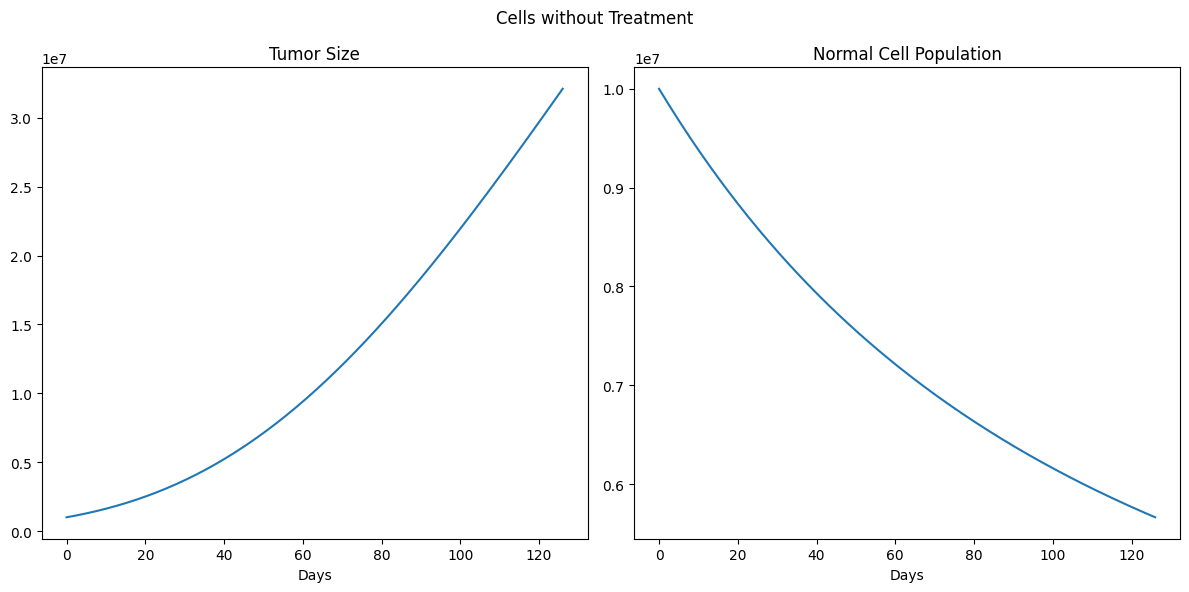

In [4]:
plt.figure(figsize=(12,6))
ts = np.linspace(0, 126, 150)
# Plot cells
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(ts, sol.sol(ts)[0])
plt.xlabel("Days")
plt.title("Tumor Size")
# Plot normal cells
plt.subplot(122)
plt.plot(ts, sol.sol(ts)[1])
plt.xlabel("Days")
plt.title("Normal Cell Population")
# Overall plot
plt.suptitle('Cells without Treatment')
plt.tight_layout()
plt.savefig('Cell_graphs.pdf', format='pdf')

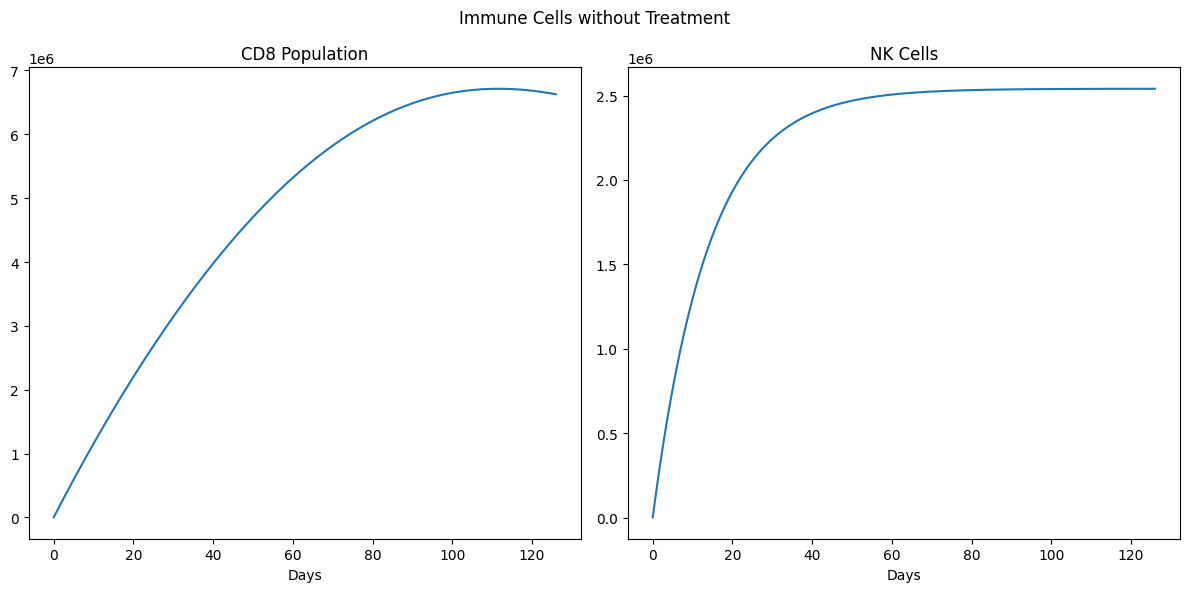

In [5]:

# Immune cells
# Plot CD8 cells
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(ts, sol.sol(ts)[2])
plt.xlabel("Days")
plt.title("CD8 Population")
# Plot NK cells
plt.subplot(122)
plt.plot(ts, sol.sol(ts)[3])
plt.xlabel("Days")
plt.title("NK Cells")
# Overall plot
plt.suptitle('Immune Cells without Treatment')
plt.tight_layout()
plt.savefig('Immune_cells.pdf', format='pdf')

## Estimate the b_CD parameter

191499081400027.8


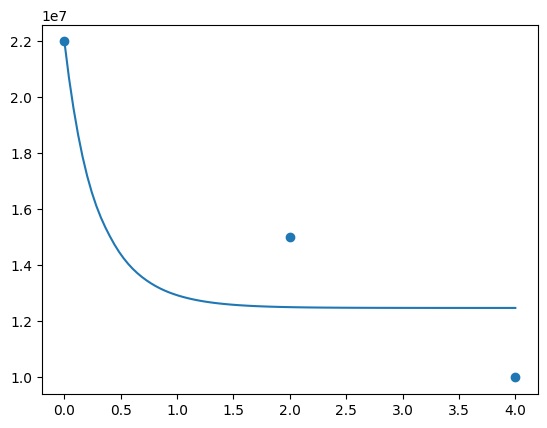

3.1687329143502736


In [6]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Sample data (time in days, CD8+ % remaining)
time_data = np.array([0, 2, 4])
CD_data = np.array([2.2e7, 1.5e7, 1e7])  # Hypothetical recovery phase

def ode(t, y, const):
    drug, CD8 = y

    drug_prime = - np.log(2)*drug / (1/4)
    CD8_prime = - const*drug*CD8
    return np.array([drug_prime, CD8_prime])
init_dose = 20*.025 # Really difficult to guess, but is 20g/kg of body weight for a tiny mouse so...

def func(const):
    sol = solve_ivp(ode, t_span=(0, 4), y0=np.array([init_dose, 2.2e7]), t_eval=np.array([0,2,4]), args=(const[0],))
    return np.sum((CD_data - sol.y[1])**2)

print(func(np.array([.01])))

res = minimize(func, np.array([.1]) )
best_const = res.x

sol = solve_ivp(ode, (0, 4), np.array([init_dose, 2.2e7]), t_eval=np.linspace(0,4,100), args=(best_const[0],))

plt.plot(sol.t, sol.y[1])
plt.scatter(time_data, CD_data)
plt.show()

print(best_const[0])
